
Average IoU: 0.3910
Average Dice Coefficient: 0.5240
Average Precision: 0.5088
Average Recall: 0.6954
Average Pixel Accuracy: 0.8785
Total time: 0h: 49m: 38.78s

Displaying image 1 of 10
IoU Score: 0.1587, Dice Coefficient: 0.2739, Precision: 0.2032, Recall: 0.4201, Pixel Accuracy: 0.7978


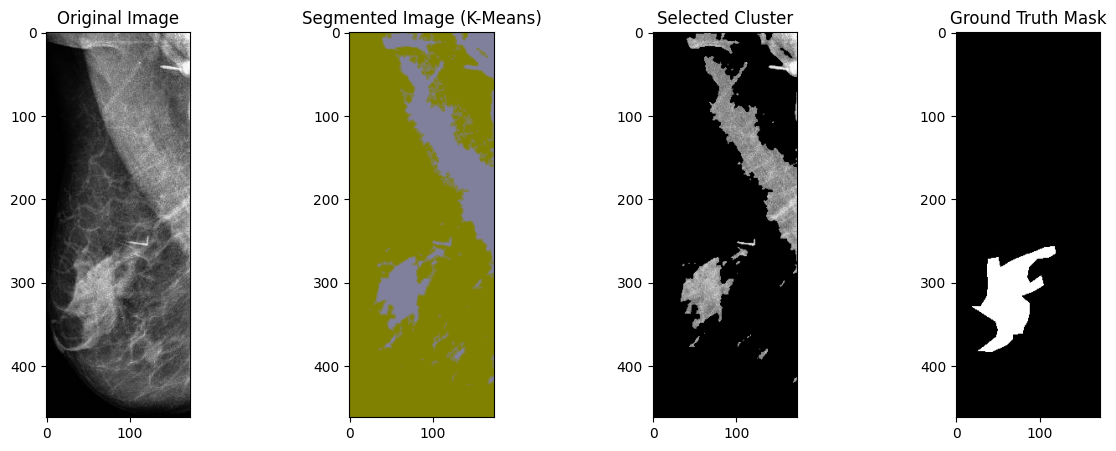


Displaying image 2 of 10
IoU Score: 0.4027, Dice Coefficient: 0.5742, Precision: 0.4570, Recall: 0.7725, Pixel Accuracy: 0.9705


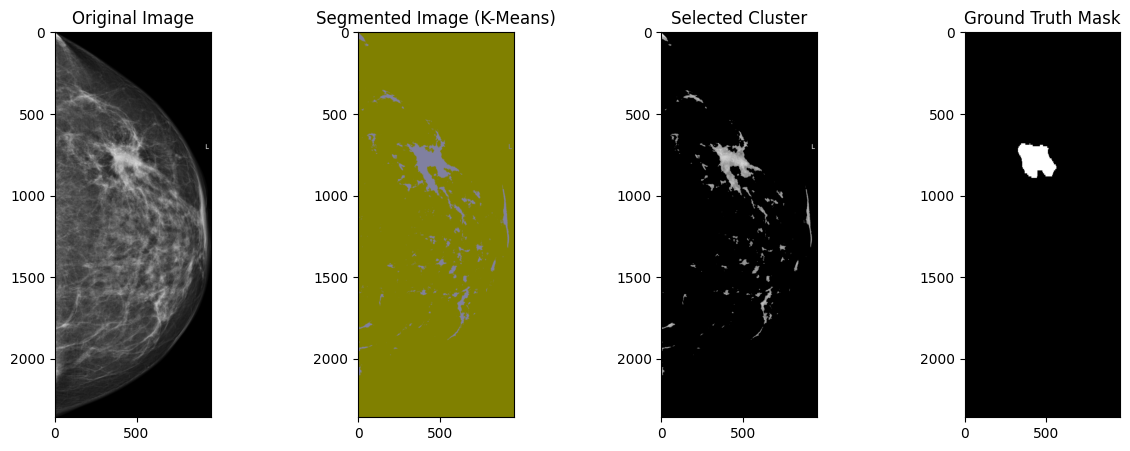


Displaying image 3 of 10
IoU Score: 0.7260, Dice Coefficient: 0.8413, Precision: 0.9949, Recall: 0.7287, Pixel Accuracy: 0.9481


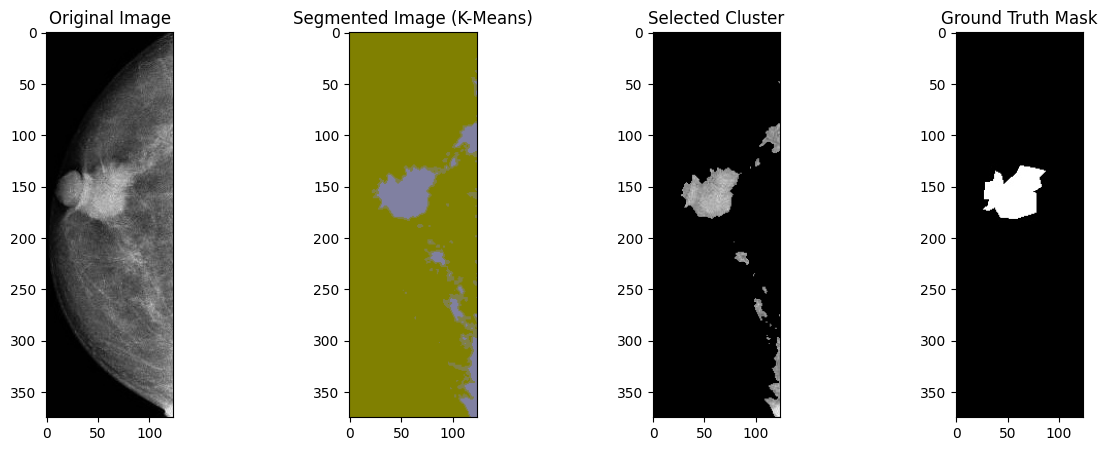


Displaying image 4 of 10
IoU Score: 0.0000, Dice Coefficient: 0.0000, Precision: 0.0000, Recall: 0.0000, Pixel Accuracy: 0.8737


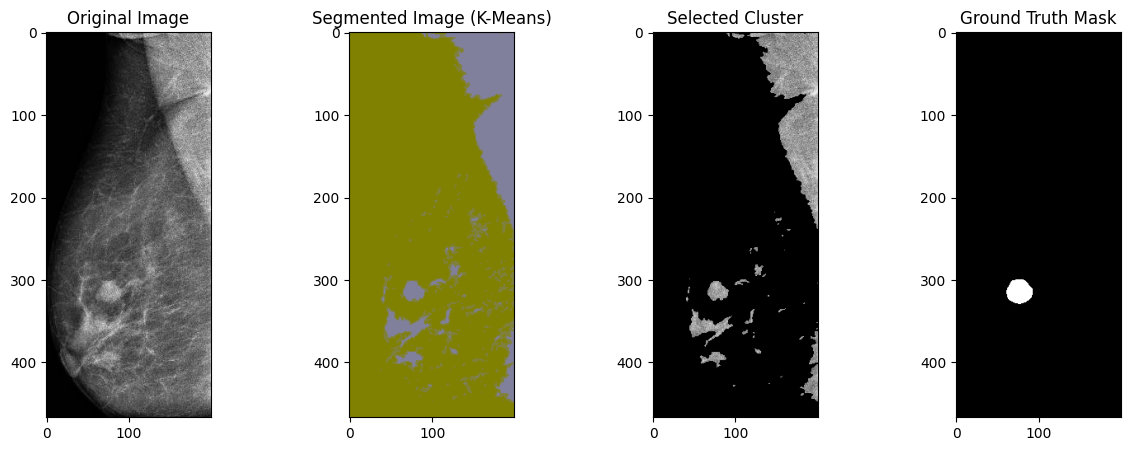


Displaying image 5 of 10
IoU Score: 0.6912, Dice Coefficient: 0.8174, Precision: 0.9281, Recall: 0.7303, Pixel Accuracy: 0.8948


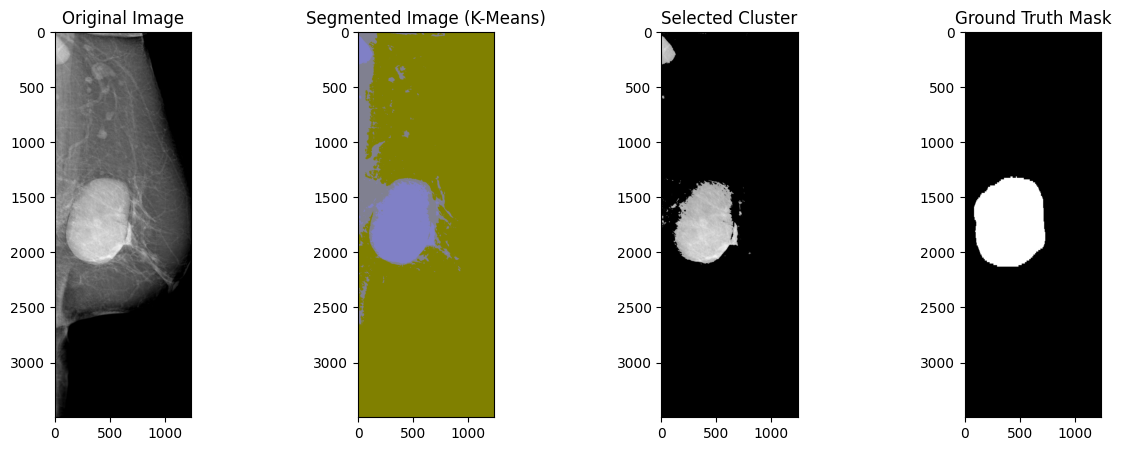


Displaying image 6 of 10
IoU Score: 0.2675, Dice Coefficient: 0.4221, Precision: 0.2949, Recall: 0.7417, Pixel Accuracy: 0.9674


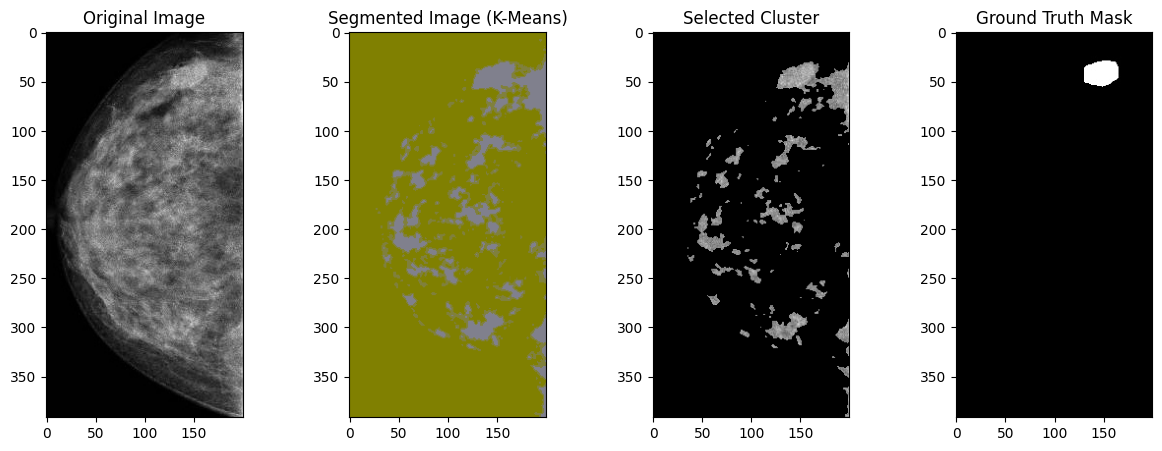


Displaying image 7 of 10
IoU Score: 0.6889, Dice Coefficient: 0.8158, Precision: 0.9993, Recall: 0.6893, Pixel Accuracy: 0.9360


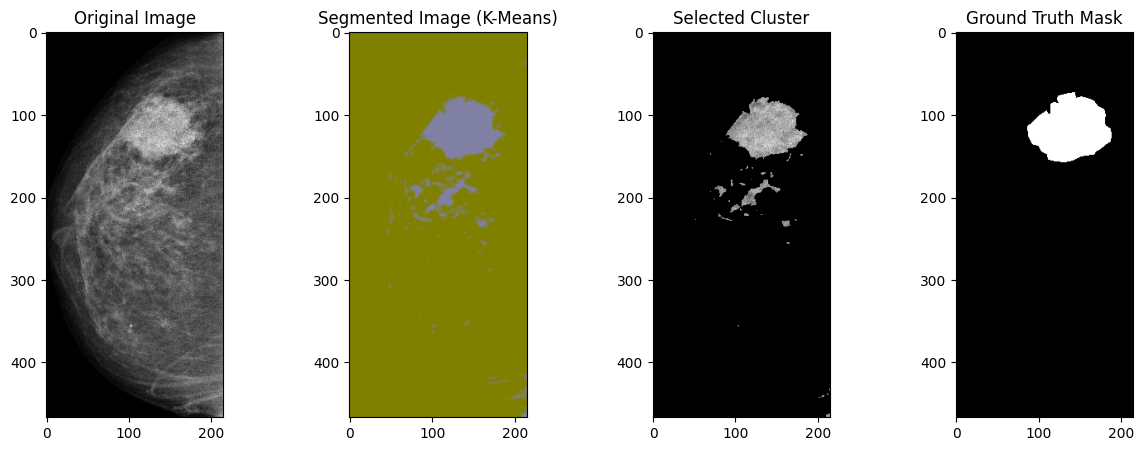


Displaying image 8 of 10
IoU Score: 0.3567, Dice Coefficient: 0.5258, Precision: 0.4634, Recall: 0.6076, Pixel Accuracy: 0.9559


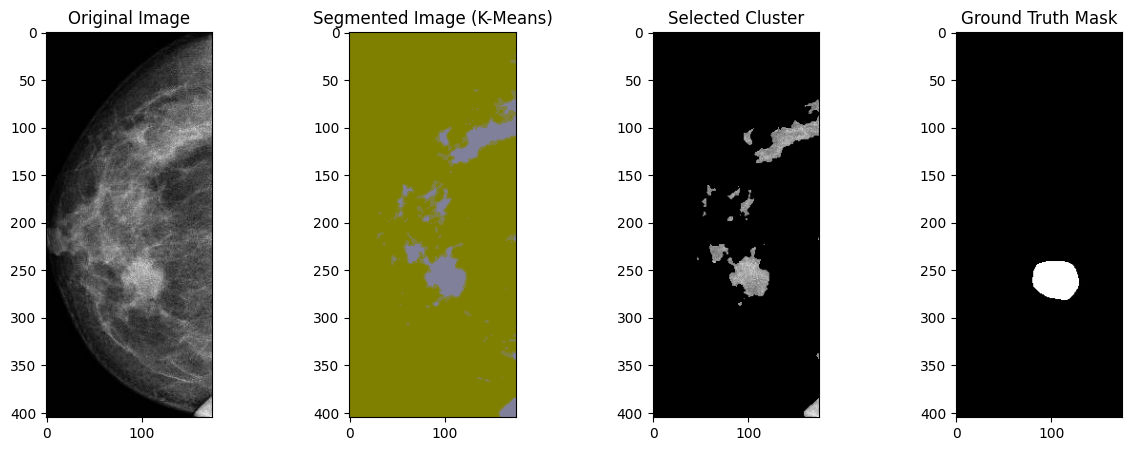


Displaying image 9 of 10
IoU Score: 0.4541, Dice Coefficient: 0.6246, Precision: 0.4713, Recall: 0.9255, Pixel Accuracy: 0.7866


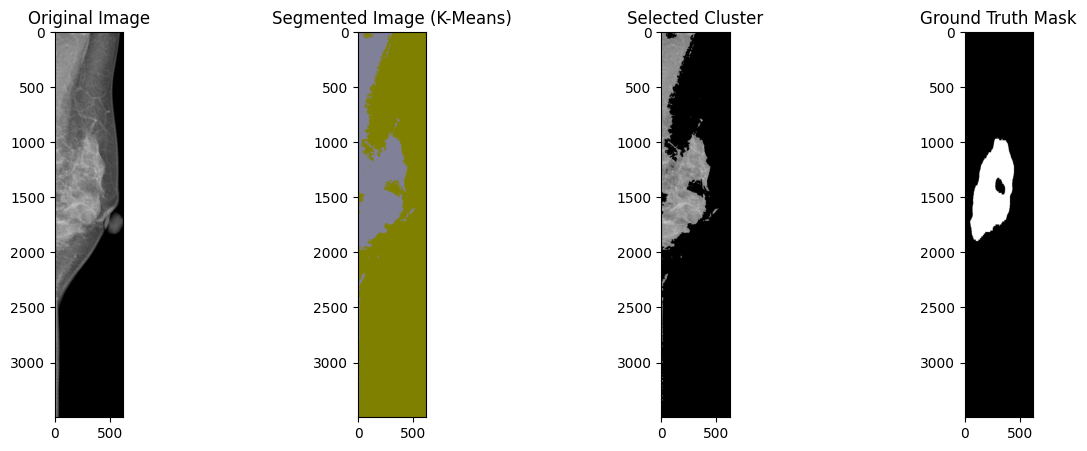


Displaying image 10 of 10
IoU Score: 0.2927, Dice Coefficient: 0.4529, Precision: 0.3098, Recall: 0.8415, Pixel Accuracy: 0.8374


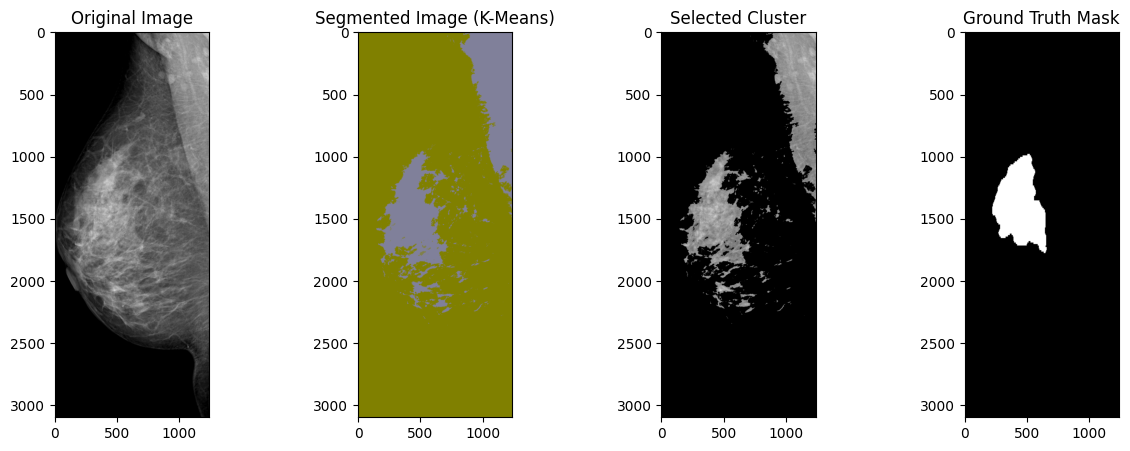

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random
import time
from sklearn.metrics import accuracy_score, classification_report

# Đường dẫn tới dataset
data_dir = '/kaggle/input/do-an-2-0/'

# Các nhãn tương ứng với các lớp
classes = ['benign', 'malignant', 'normal']

# Hàm đọc cả ảnh và mask từ thư mục
def load_images_and_masks_from_folder(folder):
    images = []
    masks = []
    for filename in os.listdir(folder):
        if '_mask' not in filename:
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
                images.append(img)
                
            mask_name = filename.replace('.jpg', '_mask.jpg')
            mask = cv2.imread(os.path.join(folder, mask_name), cv2.IMREAD_GRAYSCALE)
            if mask is not None:
                masks.append(mask)
                
    return images, masks

# Đọc tất cả ảnh và mask từ các thư mục
def load_dataset(data_dir, classes):
    images = {}
    masks = {}
    for label in classes:
        path = os.path.join(data_dir, label)
        img, mask = load_images_and_masks_from_folder(path)
        images[label] = img
        masks[label] = mask
    return images, masks

# Chuyển đổi ảnh sang không gian màu L*a*b* và chuẩn hóa để giá trị nằm trong khoảng [0, 255]
def convert_to_lab(image):
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    return lab_image

# Áp dụng K-Means clustering: Sử dụng thuật toán K-Means để phân nhóm các điểm ảnh dựa trên màu sắc
def kmeans_segmentation(image, k=3):
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=300)
    labels = kmeans.fit_predict(pixel_values)
    
    segmented_image = kmeans.cluster_centers_[labels]
    segmented_image = segmented_image.reshape(image.shape).astype(np.uint8)
    
    labels = labels.reshape(image.shape[:2])
    
    return segmented_image, labels, kmeans.cluster_centers_

# Chọn cluster dựa trên màu sắc và vị trí
def select_best_cluster(image, labels, kmeans_centers):
    cluster_means = np.mean(kmeans_centers, axis=1)
    cluster_idx = np.argmax(cluster_means)
    return select_cluster(image, labels, kmeans_centers, cluster_idx)

# Hàm chọn cluster cụ thể từ ảnh
def select_cluster(image, labels, kmeans_centers, cluster_idx):
    selected_cluster = np.zeros_like(image)
    mask = labels == cluster_idx
    selected_cluster[mask] = image[mask]
    return selected_cluster

# Áp dụng xử lý hình thái học để cải thiện kết quả phân đoạn
def postprocess_segmented_image(segmented_image):
    gray = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    
    kernel = np.ones((5, 5), np.uint8)
    opened_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
    closed_image = cv2.morphologyEx(opened_image, cv2.MORPH_CLOSE, kernel)
    
    contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    min_area = 500
    filtered_image = np.zeros_like(closed_image)
    for contour in contours:
        if cv2.contourArea(contour) > min_area:
            cv2.drawContours(filtered_image, [contour], -1, 255, thickness=cv2.FILLED)
    
    return filtered_image

# Tính IoU
def calculate_iou(mask, predicted_mask):
    intersection = np.logical_and(mask, predicted_mask)
    union = np.logical_or(mask, predicted_mask)
    if np.sum(union) == 0:
        return 0
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

# Tính Dice Coefficient (F1 Score)
def calculate_dice(mask, predicted_mask):
    intersection = np.logical_and(mask, predicted_mask)
    dice_score = 2 * np.sum(intersection) / (np.sum(mask) + np.sum(predicted_mask))
    return dice_score

# Tính Precision và Recall
def calculate_precision_recall(mask, predicted_mask):
    tp = np.sum(np.logical_and(predicted_mask, mask))
    fp = np.sum(np.logical_and(predicted_mask, np.logical_not(mask)))
    fn = np.sum(np.logical_and(np.logical_not(predicted_mask), mask))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    return precision, recall

# Tính Pixel Accuracy
def calculate_pixel_accuracy(mask, predicted_mask):
    return accuracy_score(mask.flatten(), predicted_mask.flatten())


# Hiển thị ảnh
def display_images(original, segmented, selected_cluster, mask, iou_score, dice_score, precision, recall, pixel_accuracy):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
    plt.title('Segmented Image (K-Means)')

    plt.subplot(1, 4, 3)
    plt.imshow(cv2.cvtColor(selected_cluster, cv2.COLOR_BGR2RGB))
    plt.title('Selected Cluster')

    plt.subplot(1, 4, 4)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Ground Truth Mask')
    
    plt.show()

# Phát hiện đường viền để tìm vùng quan tâm (ROI)
def contour_based_roi(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    
    result = cv2.bitwise_and(image, image, mask=mask)
    
    return result

# Tiền xử lý ảnh với phương pháp contour
def preprocess_image_with_contours(image):
    roi_image = contour_based_roi(image)
    blurred_image = cv2.GaussianBlur(roi_image, (5, 5), 0)
    return blurred_image

# Chương trình chính
def main():
    total_start_time = time.time()

    images, masks = load_dataset(data_dir, classes)

    results = []
    iou_scores = []
    dice_scores = []
    precisions = []
    recalls = []
    pixel_accuracies = []


    for label in classes:
        for idx, (image, mask) in enumerate(zip(images[label], masks[label])):
            # print(f"{label} {idx+1}")

            preprocessed_image = preprocess_image_with_contours(image)
            lab_image = convert_to_lab(preprocessed_image)
            
            segmented_image, labels, centers = kmeans_segmentation(lab_image, k=3)
            selected_cluster = select_best_cluster(image, labels, centers)
            post_processed = postprocess_segmented_image(selected_cluster)
            
            predicted_mask_resized = cv2.resize(post_processed, (mask.shape[1], mask.shape[0]), interpolation=cv2.INTER_NEAREST)
            predicted_mask = predicted_mask_resized > 0
            
            iou_score = calculate_iou(mask > 0, predicted_mask)
            dice_score = calculate_dice(mask > 0, predicted_mask)
            precision, recall = calculate_precision_recall(mask > 0, predicted_mask)
            pixel_accuracy = calculate_pixel_accuracy(mask, predicted_mask)            
            
            
            iou_scores.append(iou_score)
            dice_scores.append(dice_score)
            precisions.append(precision)
            recalls.append(recall)
            pixel_accuracies.append(pixel_accuracy)

            results.append((image, segmented_image, selected_cluster, mask, iou_score, dice_score, precision, recall, pixel_accuracy))

    average_iou = np.mean(iou_scores)
    average_dice = np.mean(dice_scores)
    average_precision = np.mean(precisions)
    average_recall = np.mean(recalls)
    average_pixel_accuracy = np.mean(pixel_accuracies)

    print(f"\nAverage IoU: {average_iou:.4f}")
    print(f"Average Dice Coefficient: {average_dice:.4f}")
    print(f"Average Precision: {average_precision:.4f}")
    print(f"Average Recall: {average_recall:.4f}")
    print(f"Average Pixel Accuracy: {average_pixel_accuracy:.4f}")

    total_time = time.time() - total_start_time
    hours, remainder = divmod(total_time, 3600)
    minutes, seconds = divmod(remainder, 60)

    print(f"Total time: {int(hours)}h: {int(minutes)}m: {seconds:.2f}s")

    num_display = min(10, len(results))
    selected_results = random.sample(results, num_display)
    
    for idx, (original, segmented, selected, mask, iou, dice, precision, recall, pixel_accuracy) in enumerate(selected_results, 1):
        print(f"\nDisplaying image {idx} of {num_display}")
        print(f"IoU Score: {iou:.4f}, Dice Coefficient: {dice:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Pixel Accuracy: {pixel_accuracy:.4f}")
        display_images(original, segmented, selected, mask, iou, dice, precision, recall, pixel_accuracy)

if __name__ == "__main__":
    main()
